In [ ]:
from gensim.models import FastText, Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import tensorflow_datasets as tfds
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Разборки с датасетами

In [ ]:
imdb_data, info = tfds.load('imdb_reviews', as_supervised=True)
train_data = imdb_data['train']
test_data = imdb_data['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZGKQYO_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZGKQYO_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ZGKQYO_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


*на данном этапе, из заготовленного набора данных с отзывами о фильмах платформы IMDB, мы загружаем данные формата обзор:настрой, что означает что там сам комментарий пользователя и 0 либо 1, что символизирует его настрой*

In [ ]:
def convertToPandas(df, limit):
    texts, labels = [], []

    for text, label in tfds.as_numpy(df.take(limit)):
        texts.append(text.decode('utf-8'))
        labels.append(int(label))
    return pd.DataFrame({"review": texts, "label": labels})

*данная функция является конвертатором из специального формата tanserflow в привычный нам pandas dataframe. Если подробнее про то как оно это делает то, он берет при помощи функции take первые limit из датасет, что символизирует размерность будущего датасета, если забежать наперед. Следом, алгоритм заключается в том что мы постепенно данные переводим в обоюдно понятный формат nympy, который в последсвтии при помощи utf-8, можно будет заново раскодировать и добавить в датасет*

In [ ]:
train_size, test_size = 15000, 15000
train_df = convertToPandas(train_data, train_size)
test_df = convertToPandas(test_data, test_size)

*как раз применяем предыдущю функцию, используя максимальные размерности для формирования датасетов. Тут я разделил на две части один датасет, поскольку требовалось в услових, хотя это особо и не пригодилось*

In [ ]:
test_df

,review,label
0,There are films that make careers. For George ...,1
1,"A blackly comic tale of a down-trodden priest,...",1
2,"Scary Movie 1-4, Epic Movie, Date Movie, Meet ...",0
3,Poor Shirley MacLaine tries hard to lend some ...,0
4,As a former Erasmus student I enjoyed this fil...,1
...,...,...
14995,Christopher Nolan's first film is a 'no budget...,1
14996,The commercials for RAT RACE made it look too ...,0
14997,"If you take the movie for what it is worth, yo...",1
14998,King of the Underworld features an early role ...,1


In [ ]:
imbDataet = pd.concat([train_df, test_df], ignore_index=True)

*обьединение в один датасет с отзывами*

In [ ]:
imbDataet

,review,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1
...,...,...
29995,Christopher Nolan's first film is a 'no budget...,1
29996,The commercials for RAT RACE made it look too ...,0
29997,"If you take the movie for what it is worth, yo...",1
29998,King of the Underworld features an early role ...,1


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*подготовка инструменто в лице NLTK, которые позволят нам токенезировать текст и убрать излишние слова которые создают шум в данных*

In [ ]:
def dataProcessing(txt):
    txt = re.sub(r'[^\w\s]', '', txt)
    txt = txt.lower()
    tokens = word_tokenize(txt)

    filtered_tokens = []
    for word in tokens:
        if word not in stop_words:
            filtered_tokens.append(word)

    return ' '.join(filtered_tokens)

*функция выполняющая основной процессинг текста для моих моделей, где удаляются знаки припенания, стоп слова, которые на восприятия модели влиять никак не буду и токенеризация*

In [ ]:
train_df['cleaned_review'] = train_df['review'].apply(dataProcessing)
test_df['cleaned_review'] = test_df['review'].apply(dataProcessing)
imbDataet['cleaned_review'] = imbDataet['review'].apply(dataProcessing)

In [ ]:
imbDataet

,review,label,cleaned_review
0,This was an absolutely terrible movie. Don't b...,0,absolutely terrible movie dont lured christoph...
1,"I have been known to fall asleep during films,...",0,known fall asleep films usually due combinatio...
2,Mann photographs the Alberta Rocky Mountains i...,0,mann photographs alberta rocky mountains super...
3,This is the kind of film for a snowy Sunday af...,1,kind film snowy sunday afternoon rest world go...
4,"As others have mentioned, all the women that g...",1,others mentioned women go nude film mostly abs...
...,...,...,...
29995,Christopher Nolan's first film is a 'no budget...,1,christopher nolans first film budget black whi...
29996,The commercials for RAT RACE made it look too ...,0,commercials rat race made look juvenile enjoy ...
29997,"If you take the movie for what it is worth, yo...",1,take movie worth wont disappointed think murra...
29998,King of the Underworld features an early role ...,1,king underworld features early role humphery b...


# Работа с моделями

In [ ]:
test_df.isnull().sum()

,0
review,0
label,0
cleaned_review,0


In [ ]:
train_df.isnull().sum()

,0
review,0
label,0
cleaned_review,0


*проверка на пропуски в данных*

In [ ]:
tokenized_data = imbDataet['cleaned_review'].apply(lambda x: x.split()).tolist()

print(tokenized_data)

*разбиение очищенных комментарий на токены в виде листов, необходимо для обучения моделей*

**Word2Vec**

In [ ]:
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=50, window=5, min_count=5, workers=4)

*вот и пробрались к построении моделей, тут строиться моделей word2vec, где можем видеть что на вход подаются наши токениризированные данные, следом идет размерность вектора которая составляет у нас 50, что по моему является достаточно оптимальным для такого обьема, следующее является своебразным окном захвата информации вокруг определенного слова, так что диапозон в виде 5 элементов выглядит достаточно уместным, следом у нас минимальное количество того сколько должно встретиться это слово в выделенном диапозоне, ну и количество потоков которые будут одновременно обрабатывать данные*

In [ ]:
target_words = ["movie", "happy", "king", "bank", "apple", 'director']
for word in target_words:
    try:
        print(f"\nWords most similar to '{word}':")
        similar_words = word2vec_model.wv.most_similar(word, topn=10)
        for similar_word, similarity in similar_words:
            print(f"{similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"Word '{word}' not in vocabulary.")


Words most similar to 'movie':
film: 0.8601
moviebr: 0.7843
movies: 0.7299
flick: 0.7175
filmbr: 0.6456
itbr: 0.6337
sequel: 0.6057
honestly: 0.5861
really: 0.5850
thing: 0.5633

Words most similar to 'happy':
sad: 0.6801
cry: 0.6619
afraid: 0.6120
satisfied: 0.6116
wanting: 0.6097
guessing: 0.6014
tears: 0.5977
glad: 0.5887
scared: 0.5794
till: 0.5776

Words most similar to 'king':
kings: 0.7899
stephen: 0.7824
lion: 0.7453
poe: 0.7342
h: 0.7159
craven: 0.7122
costello: 0.7116
james: 0.6936
edgar: 0.6905
l: 0.6894

Words most similar to 'bank':
robbery: 0.8878
gambling: 0.8760
security: 0.8744
charge: 0.8708
investigate: 0.8649
cattle: 0.8586
escaping: 0.8532
locked: 0.8511
doctors: 0.8442
winds: 0.8405

Words most similar to 'apple':
icecream: 0.9087
tx: 0.8949
mystic: 0.8948
collars: 0.8926
mvp: 0.8878
metro: 0.8851
diggers: 0.8848
olympiad: 0.8810
hq: 0.8806
overrun: 0.8790

Words most similar to 'director':
filmmaker: 0.7856
writer: 0.7244
screenwriter: 0.7199
producer: 0.6956
di

*функция которая осуществляет посик 10 наиболее близких по контекстуальным векторам и выводит их с соотвествующим коэффицентом сходства, сходство измеряется при помощи косинусного расстояния между векторами слов*

**FastText**

In [ ]:
fasttext_model = FastText(sentences=tokenized_data, vector_size=50, window=3, min_count=1, workers=4)

*сборка модели на основе токенезированных данных, которая по сути своей не сильно отличается от предыдущей, дело в том что на этот раз рассматриваемое слово делиться на анаграммы которые в базовом фомрате составляют размерность два, а именно если слово условно 123 то будут рассматриваться сразу 12 23*

In [ ]:
def searchWordes(word, model, topn=10):
    try:
        similar_words = model.wv.most_similar(word, topn=topn)
        print(f"Words most similar to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"{similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"Word '{word}' not found in the vocabulary.")

*определяет самое близкие сходства и определяет возвращая слово:коэффицент сходства*

In [ ]:
target_word = input('введи слово: ')
searchWordes(target_word, fasttext_model)

введи слово: phone
Words most similar to 'phone':
xylophone: 0.9437
megaphone: 0.9400
headphone: 0.9386
saxaphone: 0.9337
airphone: 0.9272
payphone: 0.9201
vodaphone: 0.9183
cellphone: 0.9128
earphone: 0.9086
saxophone: 0.9077


*демонстрация работы модели, впринципе тут наглядно видно, что модель не берет просто слова возле, но и по анаграммам находит сходства в разных частях и при достижении определенной частоты попадания он подпадает под рассмотр модели*

**BERT**

In [ ]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

*вот и подошли к модели на которой можно сказать на данный момент работает львиная доля моделей искуственных ителлектов, модель трансформеров, у нас на рассмотрении bert более техническое название (all-MiniLM-L6-v2)*

In [ ]:
unique_words = set(word for sentence in tokenized_data for word in sentence)

*осуществляется извлечение всех уникальных слов из токенезированного списка*

In [ ]:
def generate_embeddings(words, model):
    embeddings = {}
    for word in words:
        embeddings[word] = model.encode(word)
    return embeddings

*эмбеддер который определяет положения слов в пространстве вектаров*

In [ ]:
word_embeddings = generate_embeddings(unique_words, bert_model)

*определяем эмбеддеры для всех уникальных слов*

In [ ]:
def find_similar_words(target_word, embeddings, topn=10):
    if target_word not in embeddings:
        print(f"Word '{target_word}' not found in the vocabulary.")
        return

    target_embedding = embeddings[target_word]
    similarities = {
        word: cosine_similarity([target_embedding], [embedding])[0][0]
        for word, embedding in embeddings.items()
    }

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    print(f"Words most similar to '{target_word}':")
    for word, similarity in sorted_similarities[1:topn+1]:  # Пропускаем первое слово (само себя)
        print(f"{word}: {similarity:.4f}")

*функция которая определяет наиболее близкие слова путем сверки по косинусной мерк между эмбеддингами введенного слова и слов в слоаве*

In [ ]:
target_word = input("Введите слово для анализа: ")
find_similar_words(target_word, word_embeddings)

Введите слово для анализа: cinema
Words most similar to 'cinema':
cinéma: 1.0000
cinemas: 0.8918
cinemathis: 0.8477
cinemavery: 0.8470
cinematheques: 0.8176
films: 0.8134
cinemark: 0.8131
cinemathèque: 0.8121
cinematheque: 0.8121
cinemaloving: 0.8103


*можем увидеть, что модель достаточно точно определила слово, которая было заведомо отобранная для демонстрации сильных сторон BERT, на самом деле это модель, которая работает с контекстом слов, но не с самим, оно понимает что привело к данному результату и посредством умных алгоритмов сверяет паттерн поведения которое привело к данным результатам, благодаря этому, мы можем увидеть слово 'film', которое скорее всего word2vec потрудился бы найти а fasttext не увидел бы вовсе.*

# Random Forest

In [ ]:
labels = imbDataet['label'].values

In [ ]:
def generate_sentence_embeddings(tokenized_reviews, model):
    sentence_embeddings = []
    for tokens in tokenized_reviews:
        word_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if word_vectors:
            # Среднее значение векторов слов
            sentence_embeddings.append(np.mean(word_vectors, axis=0))
        else:
            # Если нет известных слов, добавляем нулевой вектор
            sentence_embeddings.append(np.zeros(model.vector_size))
    return np.array(sentence_embeddings)

*эмбеддер для генерации целевых предложений на которых в последсвтии будет строиться random forest классификационная модель. Почему мы не использовали эмбеддер который был у нас ранее? дело в том что, тот был под слова, этот теперь описывающий смысл всего предложения целеком*

In [ ]:
word2vec_embeddings = generate_sentence_embeddings(tokenized_data, word2vec_model)
fasttext_embeddings = generate_sentence_embeddings(tokenized_data, fasttext_model)

In [ ]:
def generate_sentence_embeddings_bert(reviews, model):
    return model.encode(reviews, convert_to_tensor=False)

*функция для эмбеддингов трансформер моделей*

In [ ]:
bert_embeddings = generate_sentence_embeddings_bert(imbDataet['cleaned_review'].tolist(), bert_model)

In [ ]:
X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(word2vec_embeddings, labels, test_size=0.2, random_state=42)
X_train_fasttext, X_test_fasttext, _, _ = train_test_split(fasttext_embeddings, labels, test_size=0.2, random_state=42)
X_train_bert, X_test_bert, _, _ = train_test_split(bert_embeddings, labels, test_size=0.2, random_state=42)

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Предсказания
    y_pred = rf_model.predict(X_test)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)

    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}\n")

*для оценки моделей*

In [ ]:
train_and_evaluate(X_train_word2vec, X_test_word2vec, y_train, y_test, "Word2Vec")
train_and_evaluate(X_train_fasttext, X_test_fasttext, y_train, y_test, "FastText")
train_and_evaluate(X_train_bert, X_test_bert, y_train, y_test, "BERT")

Results for Word2Vec:
Accuracy: 0.8203
F1 Score: 0.8203
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      3018
           1       0.81      0.83      0.82      2982

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000


Results for FastText:
Accuracy: 0.7810
F1 Score: 0.7810
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      3018
           1       0.78      0.79      0.78      2982

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000


Results for BERT:
Accuracy: 0.7843
F1 Score: 0.7843
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      3018
  

*если разбираться в получившихся метриках, можем заметить что на удивление word2vec в нашем случае занимает ледирующую позицию, хоть и с не большим отрывом, думаю, это обусловленно тем что в диапозоне охвата слова находилось достаточно синонимов ко вложенному слову. Почему же у fast-text получилось несколько хуже? считаю, что это обусловленно тем что из за n-грамм создавалась некая неопределенность. Что же насчет BERT, возможно, связанно с тем, что комментарии которые были выгруженныи в последсвтии прошли процессинг, могли все еще оставаться сложно сформулированными и сложными для восприятия моделью, так как мы помним, что BERT работает на онове подтекста, определяя значимость целых предложений*

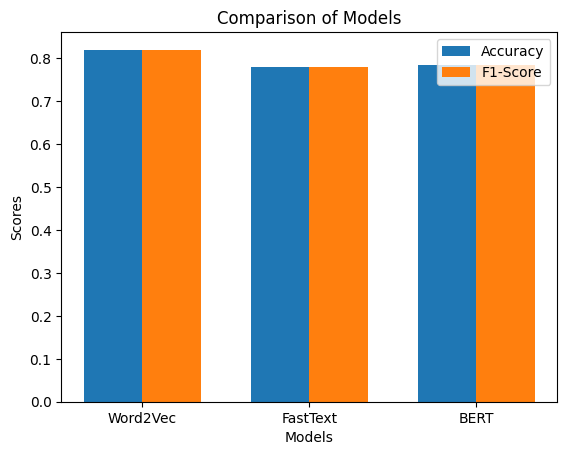

In [ ]:
# Результаты моделей
models = ['Word2Vec', 'FastText', 'BERT']
accuracy = [0.8203, 0.7810, 0.7843]
f1_scores = [0.8203, 0.7810, 0.7843]

x = np.arange(len(models))  # Позиции для каждой модели
width = 0.35  # Ширина столбца

# Построение графика
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score')

# Настройки графика
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()